# I. IMPORTATION DES BIBILIOTHEQUES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os
from google.colab import files
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader, TensorDataset




In [2]:
# ------------------ Reproductibilité ------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# II.Importation des données

In [4]:
ratings = pd.read_csv('/content/drive/MyDrive/data/Ratings.csv')

# III. EDA

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [6]:
print("Ratings:", ratings.shape)
print("\nColonnes Ratings:", ratings.columns.tolist())

Ratings: (1149780, 3)

Colonnes Ratings: ['User-ID', 'ISBN', 'Book-Rating']


In [7]:
# Aperçu des colonnes et types
print("\nRatings info:")
ratings.info()


Ratings info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


## Gestion des valeurs manquantes

In [8]:
print("\nMissing values in Ratings:")
print(ratings.isnull().sum())


Missing values in Ratings:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


## Gestion des doublons

In [9]:
# Vérifier les doublons complets (toutes colonnes identiques)
duplicates = ratings[ratings.duplicated()]

print("Nombre de doublons complets :", duplicates.shape[0])
display(duplicates)

Nombre de doublons complets : 0


,User-ID,ISBN,Book-Rating


In [10]:
print("Note minimale :", ratings['Book-Rating'].min())
print("Note maximale :", ratings['Book-Rating'].max())

Note minimale : 0
Note maximale : 10


## Distribution des notes

Statistiques des notes :
count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: Book-Rating, dtype: float64


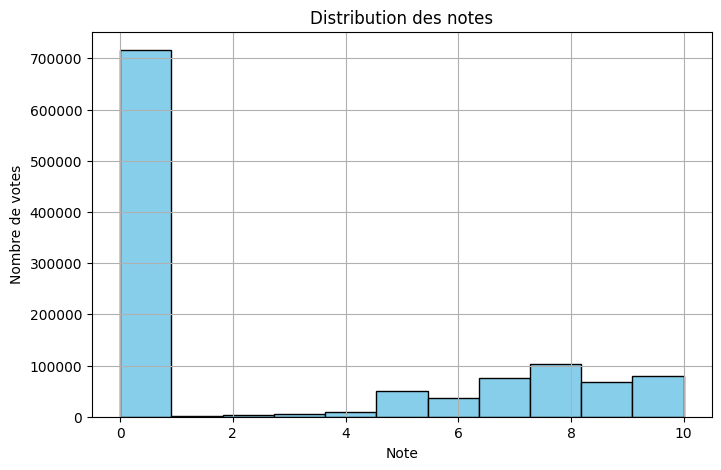

In [11]:
# Statistiques
print("Statistiques des notes :")
print(ratings['Book-Rating'].describe())

# Histogramme
plt.figure(figsize=(8,5))
ratings['Book-Rating'].hist(bins=11, color='skyblue', edgecolor='black')
plt.xlabel("Note")
plt.ylabel("Nombre de votes")
plt.title("Distribution des notes")
plt.show()

## Filtrer les utilisateurs et livres peu actifs

In [12]:
 #Filtrage utilisateurs et livres actifs
min_ratings_user = 20
min_ratings_book = 20

user_counts = ratings['User-ID'].value_counts()
book_counts = ratings['ISBN'].value_counts()

ratings_filtered = ratings[
    ratings['User-ID'].isin(user_counts[user_counts >= min_ratings_user].index) &
    ratings['ISBN'].isin(book_counts[book_counts >= min_ratings_book].index)
].copy()


print("Shape après filtrage :", ratings_filtered.shape)

Shape après filtrage : (291611, 3)


## Créer la matrice utilisateur × livre

In [13]:
user_book_matrix = ratings_filtered.pivot_table(
    index='User-ID',
    columns='ISBN',
    values='Book-Rating',
    fill_value=0
)

print("Matrice User x Book :", user_book_matrix.shape)

Matrice User x Book : (7156, 7490)


## convesion en numpy pour autoencoder

In [14]:
user_tensor_np = user_book_matrix.values.copy()

## Split Train / Test

In [15]:
# ------------------ Split train/test sécurisé ------------------
train_tensor_np = user_tensor_np.copy()
test_tensor_np = np.zeros_like(user_tensor_np)

for i in range(user_tensor_np.shape[0]):
    non_zero_idx = np.where(user_tensor_np[i] > 0)[0]
    if len(non_zero_idx) == 0:
        continue
    test_size = max(1, int(0.1 * len(non_zero_idx)))
    if test_size >= len(non_zero_idx):
        test_size = len(non_zero_idx) - 1
    if test_size <= 0:
        continue
    test_idx = np.random.choice(non_zero_idx, size=test_size, replace=False)
    train_tensor_np[i, test_idx] = 0
    test_tensor_np[i, test_idx] = user_tensor_np[i, test_idx]


## Normalisation

In [16]:
# ------------------ Centering / Normalization ------------------
# Centrer les notes par utilisateur
user_means = np.true_divide(train_tensor_np.sum(1), (train_tensor_np>0).sum(1))
user_means = np.nan_to_num(user_means)  # éviter NaN
train_tensor_centered = train_tensor_np - user_means[:, np.newaxis]
train_tensor_centered[train_tensor_np == 0] = 0  # garder les zéros

test_tensor_centered = test_tensor_np - user_means[:, np.newaxis]
test_tensor_centered[test_tensor_np == 0] = 0

# Scaling entre 0 et 1
scaler = MinMaxScaler()
train_temp = train_tensor_centered.copy()
train_temp[train_temp == 0] = np.nan
train_values = train_temp[~np.isnan(train_temp)].reshape(-1,1)
scaler.fit(train_values)

def scale_matrix(matrix, scaler):
    matrix_scaled = matrix.copy()
    mask = matrix_scaled != 0
    matrix_scaled[mask] = scaler.transform(matrix_scaled[mask].reshape(-1,1)).flatten()
    return matrix_scaled

train_tensor_scaled = scale_matrix(train_tensor_centered, scaler)
test_tensor_scaled = scale_matrix(test_tensor_centered, scaler)

train_tensor = torch.FloatTensor(train_tensor_scaled)
test_tensor = torch.FloatTensor(test_tensor_scaled)



### Masquer les zéros dans la fonction de perte (Masked Loss)

In [17]:
# ------------------ Masked Loss & RMSE ------------------
def masked_mse_loss(pred, target):
    mask = (target != 0).float()
    loss = ((pred - target)**2) * mask
    return loss.sum() / (mask.sum() + 1e-8)

def masked_rmse(pred, target):
    mask = (target != 0).float()
    mse = ((pred - target)**2) * mask
    return torch.sqrt(mse.sum() / (mask.sum() + 1e-8))

def masked_rmse_np(pred, target):
    mask = target != 0
    mse = ((pred - target)**2)[mask]
    return np.sqrt(mse.mean())


## Définir l’architecture du Denoising Autoencoder (PyTorch):

In [18]:
# ------------------ Denoising Autoencoder ------------------
class DenoisingAutoEncoder(nn.Module):
    def __init__(self, num_items, latent_dim=64, dropout_prob=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_items, 256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, latent_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, num_items),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

num_items = train_tensor.shape[1]
model = DenoisingAutoEncoder(num_items, latent_dim=64, dropout_prob=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)


### Entraînement du DAE

In [20]:
# ------------------ Entraînement simple ------------------
num_epochs = 10
batch_size = 128

train_dataset = TensorDataset(train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        batch_tensor = batch[0]

        # ------------------ Denoising 40% ------------------
        noise = (torch.rand_like(batch_tensor) < 0.4).float()
        input_noisy = batch_tensor * (1 - noise)

        optimizer.zero_grad()
        output = model(input_noisy)
        loss = masked_mse_loss(output, batch_tensor)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_tensor.size(0)

    epoch_loss /= len(train_dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}")


Epoch [1/10] Train Loss: 0.0098
Epoch [2/10] Train Loss: 0.0098
Epoch [3/10] Train Loss: 0.0098
Epoch [4/10] Train Loss: 0.0096
Epoch [5/10] Train Loss: 0.0095
Epoch [6/10] Train Loss: 0.0096
Epoch [7/10] Train Loss: 0.0094
Epoch [8/10] Train Loss: 0.0098
Epoch [9/10] Train Loss: 0.0095
Epoch [10/10] Train Loss: 0.0095


### Evaluation du modele DAE




In [21]:
# ------------------ Évaluation finale ------------------
model.eval()
with torch.no_grad():
    train_pred = model(train_tensor)
    test_pred = model(train_tensor)  # test_tensor reste inchangé

    train_rmse_norm = masked_rmse(train_pred, train_tensor)
    test_rmse_norm = masked_rmse(test_pred, test_tensor)
    print(f"\nFinal Train RMSE (0-1): {train_rmse_norm:.4f}")
    print(f"Final Test RMSE (0-1): {test_rmse_norm:.4f}")

    # Échelle originale
    train_pred_orig = scaler.inverse_transform(train_pred.numpy()) + user_means[:, np.newaxis]
    train_true_orig = train_tensor_np
    test_pred_orig = scaler.inverse_transform(test_pred.numpy()) + user_means[:, np.newaxis]
    test_true_orig = test_tensor_np

    train_rmse_orig = masked_rmse_np(train_pred_orig, train_true_orig)
    test_rmse_orig = masked_rmse_np(test_pred_orig, test_true_orig)
    print(f"Final Train RMSE (0-10): {train_rmse_orig:.4f}")
    print(f"Final Test RMSE (0-10): {test_rmse_orig:.4f}")



Final Train RMSE (0-1): 0.0929
Final Test RMSE (0-1): 0.1201
Final Train RMSE (0-10): 1.3269
Final Test RMSE (0-10): 1.7056


### Génération des recommandations


In [22]:
# ------------------ Top-N Recommandation ------------------
def recommend_books(user_index, top_n=5, cold_start=False):
    if cold_start:
        popular_books = ratings_filtered.groupby('ISBN')['Book-Rating'].sum().sort_values(ascending=False)
        return popular_books.index[:top_n]
    model.eval()
    with torch.no_grad():
        user_vector = train_tensor[user_index].unsqueeze(0)
        predicted_ratings = model(user_vector).squeeze().numpy()
    known_ratings = train_tensor[user_index].numpy()
    predicted_ratings[known_ratings > 0] = 0
    top_items = np.argsort(predicted_ratings)[-top_n:][::-1]
    return user_book_matrix.columns[top_items]

print("Top 5 recommandations utilisateur 0 :", recommend_books(0))

Top 5 recommandations utilisateur 0 : Index(['0771055706', '0836213319', '0486270556', '0140039589', '0836218663'], dtype='object', name='ISBN')


### Sauvegarder le modele DAE

In [23]:

# Sauvegarde
torch.save(model, "dae_model.pkl")
print("Modèle sauvegardé dans 'dae_model.pkl' ✅")


Modèle sauvegardé dans 'dae_model.pkl' ✅


In [1]:
import nbformat
from nbconvert import HTMLExporter

input_file = "code.ipynb"
output_file = "code.html"

nb = nbformat.read(input_file, as_version=4)

html_exporter = HTMLExporter()
(body, _) = html_exporter.from_notebook_node(nb)

with open(output_file, "w", encoding="utf-8") as f:
    f.write(body)

print("Fichier HTML généré :", output_file)

Fichier HTML généré : code.html
